In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time

import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = 'Gulliver.otf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'Gulliver'
plt.rcParams['font.sans-serif'] = prop.get_name()

plt.rcParams.update({
    "font.size": 10,  # Tamanho de fonte recomendado para artigos científicos (8-12 pt)
    "axes.labelsize": 10,  # Tamanho dos rótulos dos eixos
    "axes.titlesize": 10,  # Tamanho do título
    "xtick.labelsize": 10,  # Tamanho dos ticks do eixo X
    "ytick.labelsize": 10,  # Tamanho dos ticks do eixo Y
    "legend.fontsize": 10,  # Tamanho da legenda
})

In [2]:
def load_and_prepare_data(filepath):
    """Loads the first 5 profiles from the CSV and transposes."""
    print("  - Reading CSV file...")
    df = pd.read_csv(filepath, delimiter=';')
    df = df.rename(columns={df.columns[0]: 'hour'})
    df = df.set_index('hour')
    
    # --- Select the first 5 columns (wind profiles) ---
    df_selected = df.iloc[:, :5]
    
    df_transposed = df_selected.transpose()
    print(f"  - Data for {df_transposed.shape[0]} wind profiles loaded successfully.")
    return df_transposed

def create_joint_feature_vectors(df_annual_profiles):
    """
    Creates a single 20-dimensional feature vector for each week of the year,
    combining features from all 5 wind profiles.
    """
    num_profiles = df_annual_profiles.shape[0]
    hours_per_week = 168
    num_weeks = df_annual_profiles.shape[1] // hours_per_week
    
    print(f"  - Segmenting {num_profiles} profiles into {num_weeks} weeks...")
    
    all_feature_vectors = []
    
    for week_num in range(num_weeks):
        start_hour = week_num * hours_per_week
        end_hour = start_hour + hours_per_week
        
        joint_vector = []
        # For each profile, calculate features for the current week
        for profile_index in range(num_profiles):
            week_data = df_annual_profiles.iloc[profile_index, start_hour:end_hour]
            
            mean_val = week_data.mean()
            std_val = week_data.std()
            max_val = week_data.max()
            max_ramp = week_data.diff().abs().max()
            
            joint_vector.extend([mean_val, std_val, max_val, max_ramp])
            
        all_feature_vectors.append(joint_vector)
        
    print(f"  - Created {len(all_feature_vectors)} joint feature vectors, each with {len(all_feature_vectors[0])} dimensions.")
    return np.array(all_feature_vectors)

In [3]:
start_time = time.time()
filepath = "WT.csv"

print("\nStep 1: Loading and preparing data for the first 5 wind profiles...")
# We load the full 100 years, but will process one year for this example
df_all_data = load_and_prepare_data(filepath)

# --- Select the first 5 profiles to create ONE year of system data ---
df_annual_system = df_all_data.iloc[:5, :] 
# --------------------------------------------------------------------

print("\nStep 2: Creating joint feature vectors for each week...")
# This function now handles both segmentation and feature extraction
feature_vectors = create_joint_feature_vectors(df_annual_system)

print("\nStep 3: Scaling features...")
scaler = StandardScaler()
# Fill potential NaN values from std dev (if a week is flat) or ramp rate
features_scaled = scaler.fit_transform(np.nan_to_num(feature_vectors))
print("   - Scaling complete.")

feature_vectors


Step 1: Loading and preparing data for the first 5 wind profiles...
  - Reading CSV file...
  - Data for 5 wind profiles loaded successfully.

Step 2: Creating joint feature vectors for each week...
  - Segmenting 5 profiles into 52 weeks...
  - Created 52 joint feature vectors, each with 20 dimensions.

Step 3: Scaling features...
   - Scaling complete.


array([[0.54253359, 0.24042094, 0.92566   , ..., 0.21017227, 0.875522  ,
        0.339683  ],
       [0.49429601, 0.2137207 , 0.898092  , ..., 0.21641276, 0.915838  ,
        0.227845  ],
       [0.48684879, 0.23894496, 0.899714  , ..., 0.1606313 , 0.945106  ,
        0.1947    ],
       ...,
       [0.74225319, 0.24298359, 1.        , ..., 0.25077281, 0.992803  ,
        0.259423  ],
       [0.84911571, 0.13442289, 1.        , ..., 0.20204357, 0.995972  ,
        0.244741  ],
       [0.4302609 , 0.21865126, 0.957739  , ..., 0.24591168, 0.919602  ,
        0.274001  ]], shape=(52, 20))


Step 4: Analyzing for optimal number of clusters (k)...
  - Testing k=2...
  - Testing k=3...
  - Testing k=4...
  - Testing k=5...
  - Testing k=6...
  - Testing k=7...
  - Testing k=8...
  - Testing k=9...
  - Testing k=10...
  - Testing k=11...
  - Testing k=12...
  - Testing k=13...
  - Testing k=14...
  - Testing k=15...


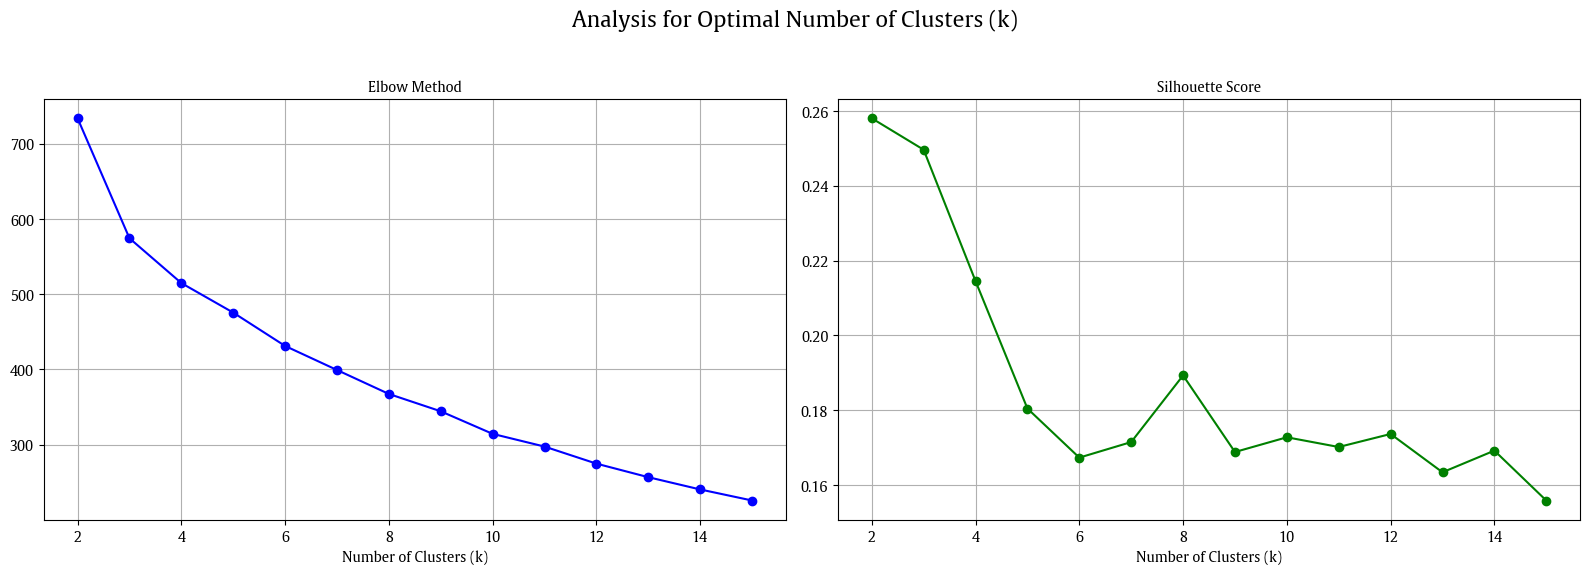


Generated plot to help choose the optimal k.


In [4]:
print("\nStep 4: Analyzing for optimal number of clusters (k)...")
inertia = []
silhouette_scores = []
K_range = range(2, 16) # Test k from 2 to 15

for k in K_range:
    print(f"  - Testing k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(features_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

# Plotting the results to find k
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Analysis for Optimal Number of Clusters (k)', fontsize=16)

# Elbow Method Plot
ax1.plot(K_range, inertia, 'bo-')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of Clusters (k)')
ax1.grid(True)

# Silhouette Score Plot
ax2.plot(K_range, silhouette_scores, 'go-')
ax2.set_title('Silhouette Score')
ax2.set_xlabel('Number of Clusters (k)')
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("\nGenerated plot to help choose the optimal k.")


Step 5: Performing final clustering with optimal k=4...
   - Clustering complete.

Step 6: Creating PCA visualization of clusters...


C:\Users\Luis\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Gulliver.
  fig.canvas.print_figure(bytes_io, **kw)


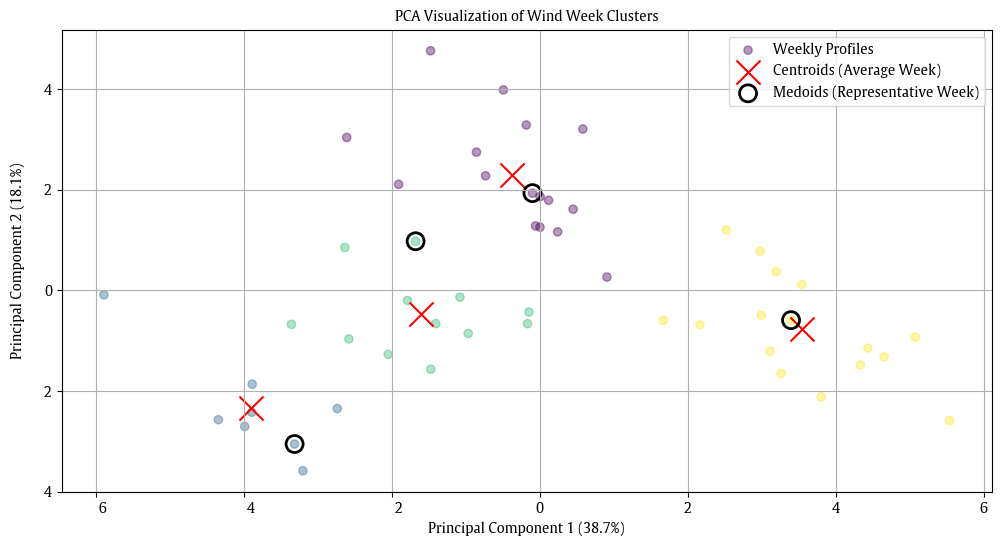

   - Generated PCA cluster visualization.


In [5]:
# --- CHOOSE YOUR 'k' HERE based on the plot from the previous cell ---
optimal_k = 4
# --------------------------------------------------------------------

print(f"\nStep 5: Performing final clustering with optimal k={optimal_k}...")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(features_scaled)
centroids = kmeans_final.cluster_centers_
print("   - Clustering complete.")

# --- Perform PCA for visualization ---
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)
centroids_pca = pca.transform(centroids)

# --- Find Medoids (representative real weeks) and their PCA coordinates ---
medoid_indices = []
for i in range(optimal_k):
    cluster_indices = np.where(labels == i)[0]
    distances = np.linalg.norm(features_scaled[cluster_indices] - centroids[i], axis=1)
    medoid_index_in_cluster = np.argmin(distances)
    medoid_original_index = cluster_indices[medoid_index_in_cluster]
    medoid_indices.append(medoid_original_index)
medoids_pca = features_pca[medoid_indices]

# --- Create PCA Visualization ---
print("\nStep 6: Creating PCA visualization of clusters...")
plt.figure(figsize=(12, 6))

# Get explained variance for plot labels
explained_variance = pca.explained_variance_ratio_

# Plot all the weekly data points
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis', alpha=0.4, label='Weekly Profiles')
# Plot the centroids (the average)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, c='red', marker='x', label='Centroids (Average Week)')
# Plot the medoids (the chosen representative real week)
plt.scatter(medoids_pca[:, 0], medoids_pca[:, 1], s=150, facecolors='none', edgecolors='black', linewidth=2, label='Medoids (Representative Week)')

plt.title('PCA Visualization of Wind Week Clusters')
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.1%})')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.1%})')
plt.legend()
plt.grid(True)
plt.show()
print("   - Generated PCA cluster visualization.")


Step 8: Plotting and saving the final representative scenarios...
  - Generated plot for Scenario 1: 'representative_scenario_1_plot.png'
  - Generated plot for Scenario 2: 'representative_scenario_2_plot.png'
  - Generated plot for Scenario 3: 'representative_scenario_3_plot.png'
  - Generated plot for Scenario 4: 'representative_scenario_4_plot.png'

Step 9: Saving representative profiles organized by wind unit...
  - Saved data for Wind Unit 1 to 'Wind_Unit_1_scenarios.csv'
  - Saved data for Wind Unit 2 to 'Wind_Unit_2_scenarios.csv'
  - Saved data for Wind Unit 3 to 'Wind_Unit_3_scenarios.csv'
  - Saved data for Wind Unit 4 to 'Wind_Unit_4_scenarios.csv'
  - Saved data for Wind Unit 5 to 'Wind_Unit_5_scenarios.csv'

--- Analysis Complete ---
Total execution time: 2.73 seconds.


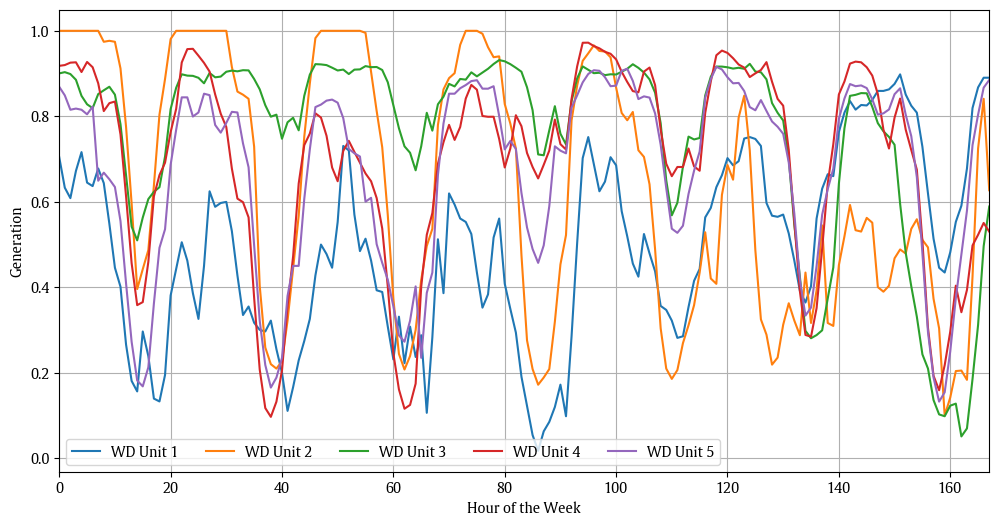

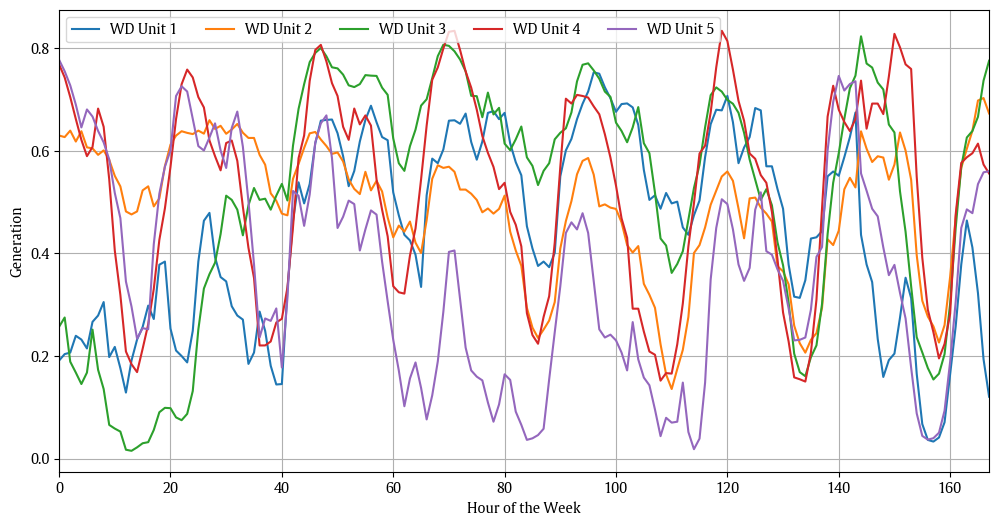

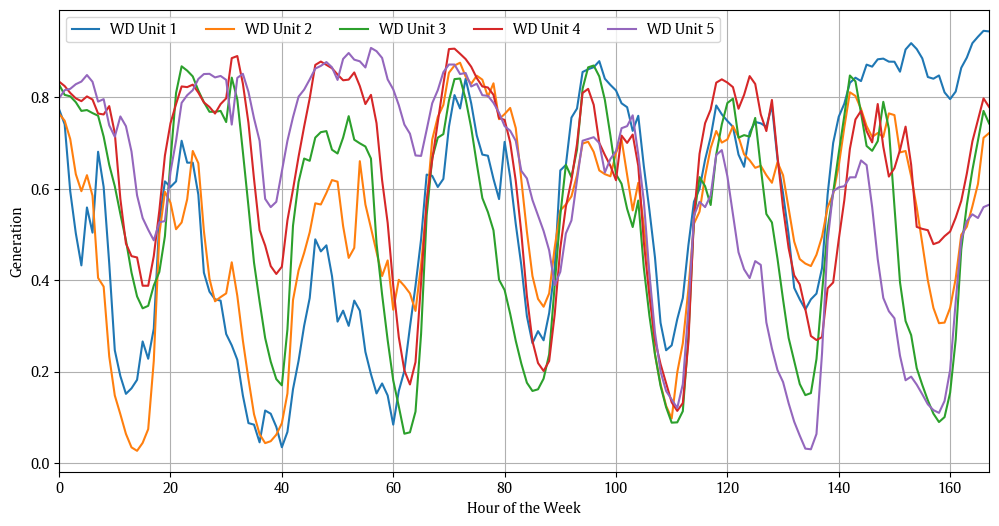

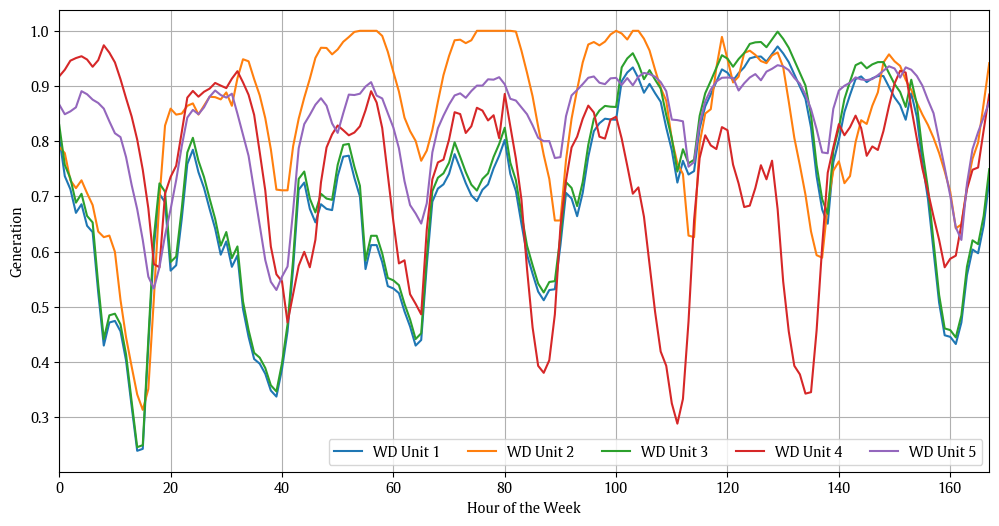

In [6]:
print("\nStep 8: Plotting and saving the final representative scenarios...")

# --- Part 1: Plotting each scenario ---
# We still need the original weekly data to retrieve the full profiles for plotting
num_weeks_per_year = 52
hours_per_week = 168
required_hours = num_weeks_per_year * hours_per_week
df_weeks_all_profiles = []
for i in range(df_annual_system.shape[0]):
    weekly_data = df_annual_system.iloc[i, :required_hours].values.reshape(num_weeks_per_year, hours_per_week)
    df_weeks_all_profiles.append(pd.DataFrame(weekly_data))

# Loop through each found scenario to plot it
for i, medoid_index in enumerate(medoid_indices):
    probability = (labels == i).sum() / len(labels)
    plt.figure(figsize=(12, 6))
    
    for profile_num in range(df_annual_system.shape[0]):
        # Get the medoid week's profile for each of the 5 wind units
        representative_profile = df_weeks_all_profiles[profile_num].iloc[medoid_index]
        plt.plot(representative_profile.index, representative_profile.values, label=f'WD Unit {profile_num + 1}')
    
    # plt.title(f'Representative Scenario {i+1} (Prob: {probability:.2%}) - Original Week #{medoid_index}')
    plt.xlabel('Hour of the Week')
    plt.ylabel('Generation')
    plt.legend(ncol=5)
    plt.grid(True)
    plt.xlim(0, 167)
    plt.savefig(f"representative_scenario_{i+1}_plot.png")
    print(f"  - Generated plot for Scenario {i+1}: 'representative_scenario_{i+1}_plot.png'")

# --- Part 2: Saving data by Wind Unit ---
print("\nStep 9: Saving representative profiles organized by wind unit...")
# Loop through each of the 5 wind units
for unit_num in range(df_annual_system.shape[0]):
    # Create a new DataFrame for this specific wind unit
    unit_scenarios_df = pd.DataFrame()
    
    # Loop through each of the 'k' scenarios we found
    for i, medoid_index in enumerate(medoid_indices):
        # Get the representative profile for this unit in this scenario
        profile = df_weeks_all_profiles[unit_num].iloc[medoid_index]
        # Add it as a new column to our DataFrame
        unit_scenarios_df[f'Scenario_{i+1}'] = profile.values
        
    # Save the completed DataFrame to a CSV file for this unit
    filename = f"Wind_Unit_{unit_num + 1}_scenarios.csv"
    unit_scenarios_df.to_csv(filename)
    print(f"  - Saved data for Wind Unit {unit_num + 1} to '{filename}'")

end_time = time.time()
print(f"\n--- Analysis Complete ---")
print(f"Total execution time: {end_time - start_time:.2f} seconds.")